In [1]:
import numpy as np
from tqdm import tqdm, trange
import math
import cmath
import warnings

In [2]:
# fixed parameter
S0 = 60
K = 50
k = math.log(K)
r = 0.05
q = 0.01

# parameters for fft 
n = 12
N = 2**n

#step - size
eta = 0.25
#damping factor
alpha = 1.5

# step -sixe in log strike space
lamda = (2*math.pi/N)/eta

# choice. of beta
#beta = np.log(S0) - N*lamda/2
beta = np.log(K)

In [22]:
def get_params(model,num):
    params = []
    if model == 'GBM':
        sig = 0.3
        params.append(sig)
        return params

    elif model == 'VG':   
        sig = 0.3
        nu = 0.5
        theta = -0.4


        params.append(sig)
        params.append(nu)
        params.append(theta)   
        return params
    elif model == 'Heston':  
        kappa = 2.0
        theta = -0.4
        sig = 0.3
        rho = 0.5
        v0 = 0.04


        params.append(kappa)
        params.append(theta)
        params.append(sig)
        params.append(rho)
        params.append(v0)
        return params
    

    elif model == 'Merton_Normal':   
        sig = 0.3
        poi_lamda = 0.5
        mu_normal = 0.8
        sig_normal = 0.2

        params.append(sig )
        params.append(poi_lamda)
        params.append(mu_normal)
        params.append(sig_normal)
        return params

    elif model == 'Merton_Double_exp':  


        prob = 0.9
        sig = 0.3
        poi_lamda = 1
        
        g_alpha_1 = 0.5
        g_alpha_2 = 2
        k_exp = prob(g_alpha_1/(g_alpha_1-1)) + (1-prob)(g_alpha_2/(g_alpha_2+1))


        params.append(prob)
        params.append(sig)
        params.append(poi_lamda)
        params.append(g_alpha_1)
        params.append(g_alpha_2)
        params.append(g_alpha_2)
         params.append(k_exp)
    
        return params

    elif model == 'Merton_Double_gamma': 
        if num == 1:

            prob = 0.9
            sig = 0.3
            poi_lamda = 1
            g_beta_plus = 1.2
            g_alpha_plus = 0.5
            g_beta_minus = 1.2
            g_alpha_minus = 2

            params.append(prob)
            params.append(sig)
            params.append(poi_lamda)
            
            params.append(g_beta_plus)
            params.append(g_alpha_plus)
            params.append(g_beta_minus)
            params.append(g_alpha_minus)



            return params

In [23]:
params1 = get_params('Merton_Double_gamma',1)

In [24]:
params1 

[0.9, 1.2, 0.5, 1.2, 2, 0.3, 1]

In [26]:
def generic_cf(u, S0, r, q, T, model,num):
    if model == "GBM":
        params = get_params("GBM",num)
        sig = params[0]
        ln_phi = 1j*(np.log(S0) + (r - q - sig ** 2 / 2) *  T)* u - \
                ((sig * np.sqrt(T)* u) ** 2 ) / 2
        cf = np.exp(ln_phi)
#             print(cf)

        return cf

    elif model == "Heston":
        params = get_params("Heston",num)
        kappa = params[0]
        theta = params[1]
        sig = params[2]
        rho = params[3]
        v0 = params[4]
            
        temp1 = kappa - 1j * rho * sig * u
        gamma = np.sqrt((sig ** 2) * (u ** 2 + 1j * u) + temp1 ** 2)

        pow1 = 2 * kappa * theta / (sig ** 2)
        
        # number 1
        ele1 = (kappa * theta * T * temp1 )/ (sig ** 2)
        ele2 = 1j * u * r * T
        ele3 = 1j * u * np.log(S0)
        numer1 = ele1 + ele2 + ele3
            
        # log_denum1
        dele1 = np.cosh(gamma * T / 2)
        dele2 = (temp1 / gamma) * np.sinh(gamma * T / 2)
        dele3 = (u ** 2 + 1j * u) * v0
        dele3 = gamma / np.tanh(gamma * T / 2)
        dele4 = temp1
            
        log_denum1 = pow1*np.log(dele1)+dele2
        temp2 = dele3/(dele3 + dele4)
        log_phi = numer1 - log_denum1 - temp2
        cf = np.exp(log_phi)
        return cf

    if model == "Merton_Normal": 
        params = get_params("Merton_Normal",num)
        sig= params[0]
        poi_lamda= params[1]
        mu_normal= params[2]
        sig_normal= params[3]
        ln_phi = 1j*(np.log(S0) + (r - q - poi_lamda-sig ** 2 / 2) *  T)* u - \
                    ((sig * np.sqrt(T)* u) ** 2 ) / 2 + \
                    poi_lamda*T*( np.exp( 1j*u*mu_normal - ((sig_normal* u) ** 2) / 2 ) - 1)
        cf = np.exp(ln_phi)
        #             print(cf)

        return cf
    if model == "Merton_Double_gamma":
        params = get_params("Merton_Double_gamma",num)
        prob= params[0]
        g_beta_plus= params[1]
        g_alpha_plus= params[2]
        g_beta_minus= params[3]
        g_alpha_minus= params[4]
        sig= params[5]
        poi_lamda= params[6]

        ln_phi = 1j*(np.log(S0) + (r - q - sig ** 2 / 2) *  T)* u - \
                ((sig * np.sqrt(T)* u) ** 2 ) / 2 + \
                poi_lamda*T*( prob*(1-(1j*u/g_beta_plus)**(-g_alpha_plus)) + (1-prob)*(1+(1j*u/g_beta_minus)**(-g_alpha_minus)) )
        cf = np.exp(ln_phi)
    #             print(cf)

        return cf

In [27]:
def evaluate_integral(S0, K, r, q, T, alpha, N, eta, model,num):
    df = np.exp(-r*T)
    beta = np.log(K)
    sum1 = 0
    for j in range(N):
        nuj = j * eta
        tmp1 = alpha + 1j * nuj  
        psi_nuJ = df*generic_cf(nuj  - (alpha + 1) * 1j, S0, r, q, T, model,num)/(tmp1 * (tmp1 + 1))
        if j == 0:
            wj = eta/2
        else:
            wj = eta
        sum1 += np.exp(-1j * beta * nuj )* psi_nuJ*wj
    CT_k = (np.exp(-alpha * k) / math.pi)*sum1
    
    return np.real(CT_k)


In [28]:
 def integrate_CF_Pack_FFT(S0, K, r, q, T, alpha, N, eta, model,num):

        sumC0T = 0
        lamda = 2 * np.pi / (N * eta)
        k = np.log(K)
        
        # 設定法一： 使km在S0兩側
        # beta = np.log(S0) - (N / 2)
        
        # 設定法二：使km從特定K開始向上加
        beta = np.log(K)
        # k 改 km
        # km = beta + (m - 1) * lda
        
        km = np.zeros(N)
        xX = np.zeros(N)
        
        #discount factor
        df = np.exp(-r*T)
        nuJ = np.arange(N)*eta
        tmp1 = alpha + 1j * nuJ 
        psi_nuJ = generic_cf(nuJ - (alpha + 1) * 1j, S0, r, q, T, model,num)/(tmp1 * (tmp1 + 1))
        
        
        # 可向量化
        for j in range(N):
#             nuj = (j - 1) * eta
#             psij = self.psi(nuj, alpha)
            km[j] = beta+j*lamda
            if j == 0:
                wj = eta/2
            else:
                wj = eta
            xX[j] =  np.exp(-1j * beta * nuJ[j])*df*psi_nuJ[j]*wj


        yY = np.fft.fft(xX)
        CT_km = np.zeros(N)
        for i in range(N):
            mulTerm = np.exp(-alpha * km[i]) / np.pi
            CT_km[i] = mulTerm * np.real(yY[i])
            

        return km, CT_km


In [29]:
model = "Merton_Double_gamma"
print(' ')
print('--'*10)
print(f'Model is: {model}')
T = 1
num = 1

km, CT_km = integrate_CF_Pack_FFT( S0, K, r, q, T, alpha, N, eta, model,num)
print(km)
print(CT_km)
a = CT_km[0]
print(a)
print('--'*10)
CT_k_1 = evaluate_integral(S0, K, r, q, T, alpha, N, eta, model,num)
print(CT_k_1)

 
--------------------
Model is: Merton_Double_gamma
[ 3.91202301  3.91815893  3.92429485 ... 29.02635646 29.03249239
 29.03862831]
[7.45138637e+01 7.38299816e+01 7.31499743e+01 ... 3.24824100e-15
 3.21874608e-15 3.18941408e-15]
74.51386366208038
--------------------
74.5138636620804


/var/folders/zl/whn4wn617zx2w7kcvhl0yy5r0000gn/T/ipykernel_2355/708912553.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  xX[j] =  np.exp(-1j * beta * nuJ[j])*df*psi_nuJ[j]*wj


In [31]:
print(' ')
print('--'*10)
print(f'Model is: {model}')

T = 1

S_array = np.arange(100) 
CT_k_array = []
for S0 in S_array:
    CT_k_1 = evaluate_integral(S0, K, r, q, T, alpha, N, eta, model,num)
#     print(CT_k_1)
    CT_k_array.append(CT_k_1)


 
--------------------
Model is: Merton_Double_gamma


/var/folders/zl/whn4wn617zx2w7kcvhl0yy5r0000gn/T/ipykernel_2355/1576287637.py:85: RuntimeWarning: divide by zero encountered in log
  ln_phi = 1j*(np.log(S0) + (r - q - sig ** 2 / 2) *  T)* u - \


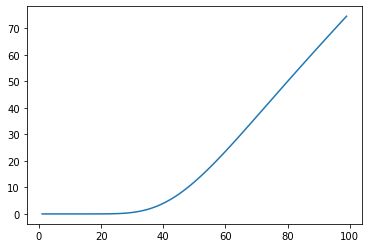

In [32]:
import matplotlib.pyplot as plt


fig = plt.figure()
plt.plot(S_array, CT_k_array)

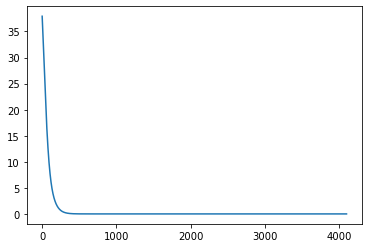

In [30]:
fig = plt.figure()
plt.plot(CT_km)